In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
# import statsmodels.api as sm
from tqdm import tqdm
# from multiprocessing.dummy import Pool
import dask.dataframe as dd
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# pd.set_option('display.max_columns', 500)

In [9]:
#In[] 1,227,297,915 size, 7675it * 10000
crsp_df = pd.read_csv("crsp_d.csv",header=0,
             parse_dates = ['date','DCLRDT','RCRDDT'],
             dtype={
                  "PERMNO": str,
                  "PRC": np.float64,
                  "VOL": np.float64,
                  "SHROUT": np.float64,
                  "DIVAMT": np.float64,
                  "SHRCD":str,
                  "DISTCD":str,
                  "COMNAM": str,
                  "TICKER": str,
                   'CUSIP': str,
                   "BID": np.float64,
                   "ASK": np.float64}, chunksize=100000)
#Data Preprocessing
#In[]
d = {}
one = False
def insert(i,x):
     if str(x)[-1].isdigit() == False:
          return
     x = float(x)
     if i not in d:
          d[i] = [x]
     else:
          d[i].append(x)
     return

for c in tqdm(crsp_df):
     c = c[(c.SHRCD.isin(('10','11'))) ]
     c = c.groupby(by=['CUSIP','date']).agg({
          'DCLRDT': 'last',
          'RCRDDT': 'last',
          'DISTCD': 'last',
          'DIVAMT': 'sum',
          'RET':'last',
          'RETX':'last',
          'PRC': 'last'}).reset_index()
     if not one:
          cusip = c.head(1).reset_index().iloc[0].CUSIP
          one = True
     count = 0
     # c['dt'] = 0
     lastDivDate = None
     for row in c.itertuples():
          if row.CUSIP != cusip:
               cusip = row.CUSIP
               # row.dt = 0
               count = 0
               lastDivDate = None
          else:
               if pd.isna(row.RCRDDT) == False:
                    lastDivDate = True
                    count = 0
                    insert(count, row.RET)
                    count += 1
               else:
                    if lastDivDate is None:
                         # row.dt = 0
                         count = 0
                    else:
                         # row.dt = count
                         insert(count, row.RET)
                         count += 1

819it [23:24,  1.71s/it]


In [3]:
crsp_rev_df = pd.read_csv("crsp_d_rev2.csv",header=0,
             parse_dates = ['date','DCLRDT','RCRDDT'],
             dtype={
                  "PERMNO": str,
                  "PRC": np.float64,
                  "VOL": np.float64,
                  "SHROUT": np.float64,
                  "DIVAMT": np.float64,
                  "SHRCD":str,
                  "DISTCD":str,
                  "COMNAM": str,
                  "TICKER": str,
                   'CUSIP': str,
                   "BID": np.float64,
                   "ASK": np.float64}, chunksize=100000)
one = False
for c in tqdm(crsp_rev_df):
     c = c[(c.SHRCD.isin(('10','11'))) ]
     c = c.groupby(by=['CUSIP','date']).agg({
          'DCLRDT': 'last',
          'RCRDDT': 'last',
          'DISTCD': 'last',
          'DIVAMT': 'sum',
          'RET':'last',
          'RETX':'last',
          'PRC': 'last'}).reset_index()
     if not one:
          cusip = c.head(1).reset_index().iloc[0].CUSIP
          one = True
     count = 0
     # c['dt'] = 0
     lastDivDate = None
     for row in c.itertuples():
          if row.CUSIP != cusip:
               cusip = row.CUSIP
               # row.dt = 0
               count = 0
               lastDivDate = None
          else:
               if pd.isna(row.RCRDDT) == False:
                    lastDivDate = True
                    count = 0
                    # insert(count, row.RET)
                    count += 1
               else:
                    if lastDivDate is None:
                         # row.dt = 0
                         count = 0
                    else:
                         # row.dt = count
                         insert(count * -1 , row.RET)
                         count += 1


723it [33:08,  3.26s/it]C:\Users\kobe\anaconda3\envs\fina4359\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (10,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
819it [38:25,  2.81s/it]


In [4]:
x = range(-30, 61, 1)
dlist = [ 100*sum(d[key])/len(d[key]) for key in x ]
print(dlist)

[0.041122103546797455, 0.03338023626550777, 0.05857059672542417, 0.053305596863286106, 0.07136886454620292, 0.06331892021437355, 0.05446396190680311, 0.06986640594165397, 0.0714888324550434, 0.07291346657480584, 0.04961563505101613, 0.05091282722832137, 0.06436233973060153, 0.07114339726437621, 0.08184597467209474, 0.04995814912254257, 0.07272333166303604, 0.07421008062328964, 0.07493897386001487, 0.06332843956554768, 0.027076160065643888, 0.035434894050854794, 0.03154639113285756, 0.04134026594141966, 0.03548514810229202, -0.004761825094754208, 0.04694929411367026, 0.049208066348376225, 0.05101440145210568, 0.058636115713624364, -0.5798437902972373, 0.05864823339378235, 0.050986772334578136, 0.04922299548185401, 0.046993172353718866, -0.0048047016224441585, 0.03552722016536012, 0.041310782028821554, 0.0315985346983128, 0.0354325727422662, 0.02711712367834887, 0.06332719331111807, 0.07491804235086617, 0.07430494118356112, 0.07283122757377193, 0.050019561833952876, 0.08185780647714802, 

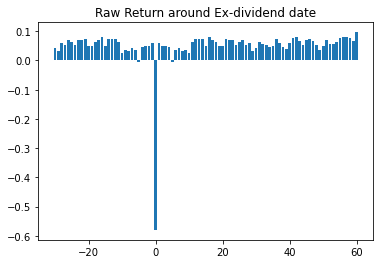

In [6]:
plt.bar(x,dlist)
plt.title('Raw Return around Ex-dividend date')
plt.show()

In [7]:
import pickle
filename = 'RCRDDT_Figure2.pkl'
with open(filename,'wb') as f:
     pickle.dump(dlist, f)

In [8]:
with open(filename,'rb') as f:
     a = pickle.load(f)

a == dlist

NameError: name 'filename' is not defined